# Week 14

### Topic
 1. Import our gaussian mixture models as usual
 1. CV with tuning function
 1. BACK TO SLIDES TO TALK ABOUT BOOTSTRAPPING
 1. Bootstrapping with tuning function


In [22]:
# resize
require(repr)
options(repr.plot.width=10, repr.plot.height=8, repr.plot.res=300)

Loading required package: repr



## 1. Import gaussian mixture models -- this is in the starter R file

RECALL: to probe KNN we will do this in steps
  1. generate some "fake" sample data from a known distribution
  2. use this fake data to "train" our KNN
  3. we can see how well we do/try to calculate the boundary between 2 distributions
  4. Now this week: we'll start quantifying the test/training errors on this simulated dataset
  5. we'll explore validatian methods (assuming we don't know anything about the underlying population/model)

Let's upload all the package we had to install last time:

In [23]:
#install.packages("mvtnorm") # run once
#install.packages("flexclust") # run once

library(dplyr)
library(mvtnorm)
library(flexclust)
library(class)
library(tidyverse)
library(stringr)

We'll also be using some helpful scripts from the STOR390 GitHub page:

In [24]:
source('https://raw.githubusercontent.com/idc9/stor390/master/notes/cross_validation/synthetic_distributions.R')
source('https://raw.githubusercontent.com/idc9/stor390/master/notes/cross_validation/knn_functions.R')

We'll use the plotting function from last lecture to do the plotting for us:

In [25]:
source('https://raw.githubusercontent.com/jnaiman/is507_fall2020/master/week13/classification_plotting_function.R')

RECALL: we will now draw points from 2D gaussians, i.e. normal distributions one gaussian will be tagged as "1", the other as "-1".

We made 2 random choices:
 1. where the center of each gaussian/normal distribution is
 2. x1 & x2 coordinates

Here we'll grab our training data from the underlying population:

In [26]:
# first, we fix the "mean seed" so this chooses where each 2D gaussian is placed
mean_seed = 238

# If we recall to last week, to get the same distribution every time, we need to 
#  have the same means & the same random drawing, we fix this with:
data_seed = 53272

# then for our underlying simulated population, lets take 2000 points of pos & 2000 points of neg
n_neg = 200
n_pos = 200

train_data = gmm_distribution2d(n_neg=n_neg, n_pos=n_pos, mean_seed=mean_seed, data_seed=data_seed)

Let's plot:

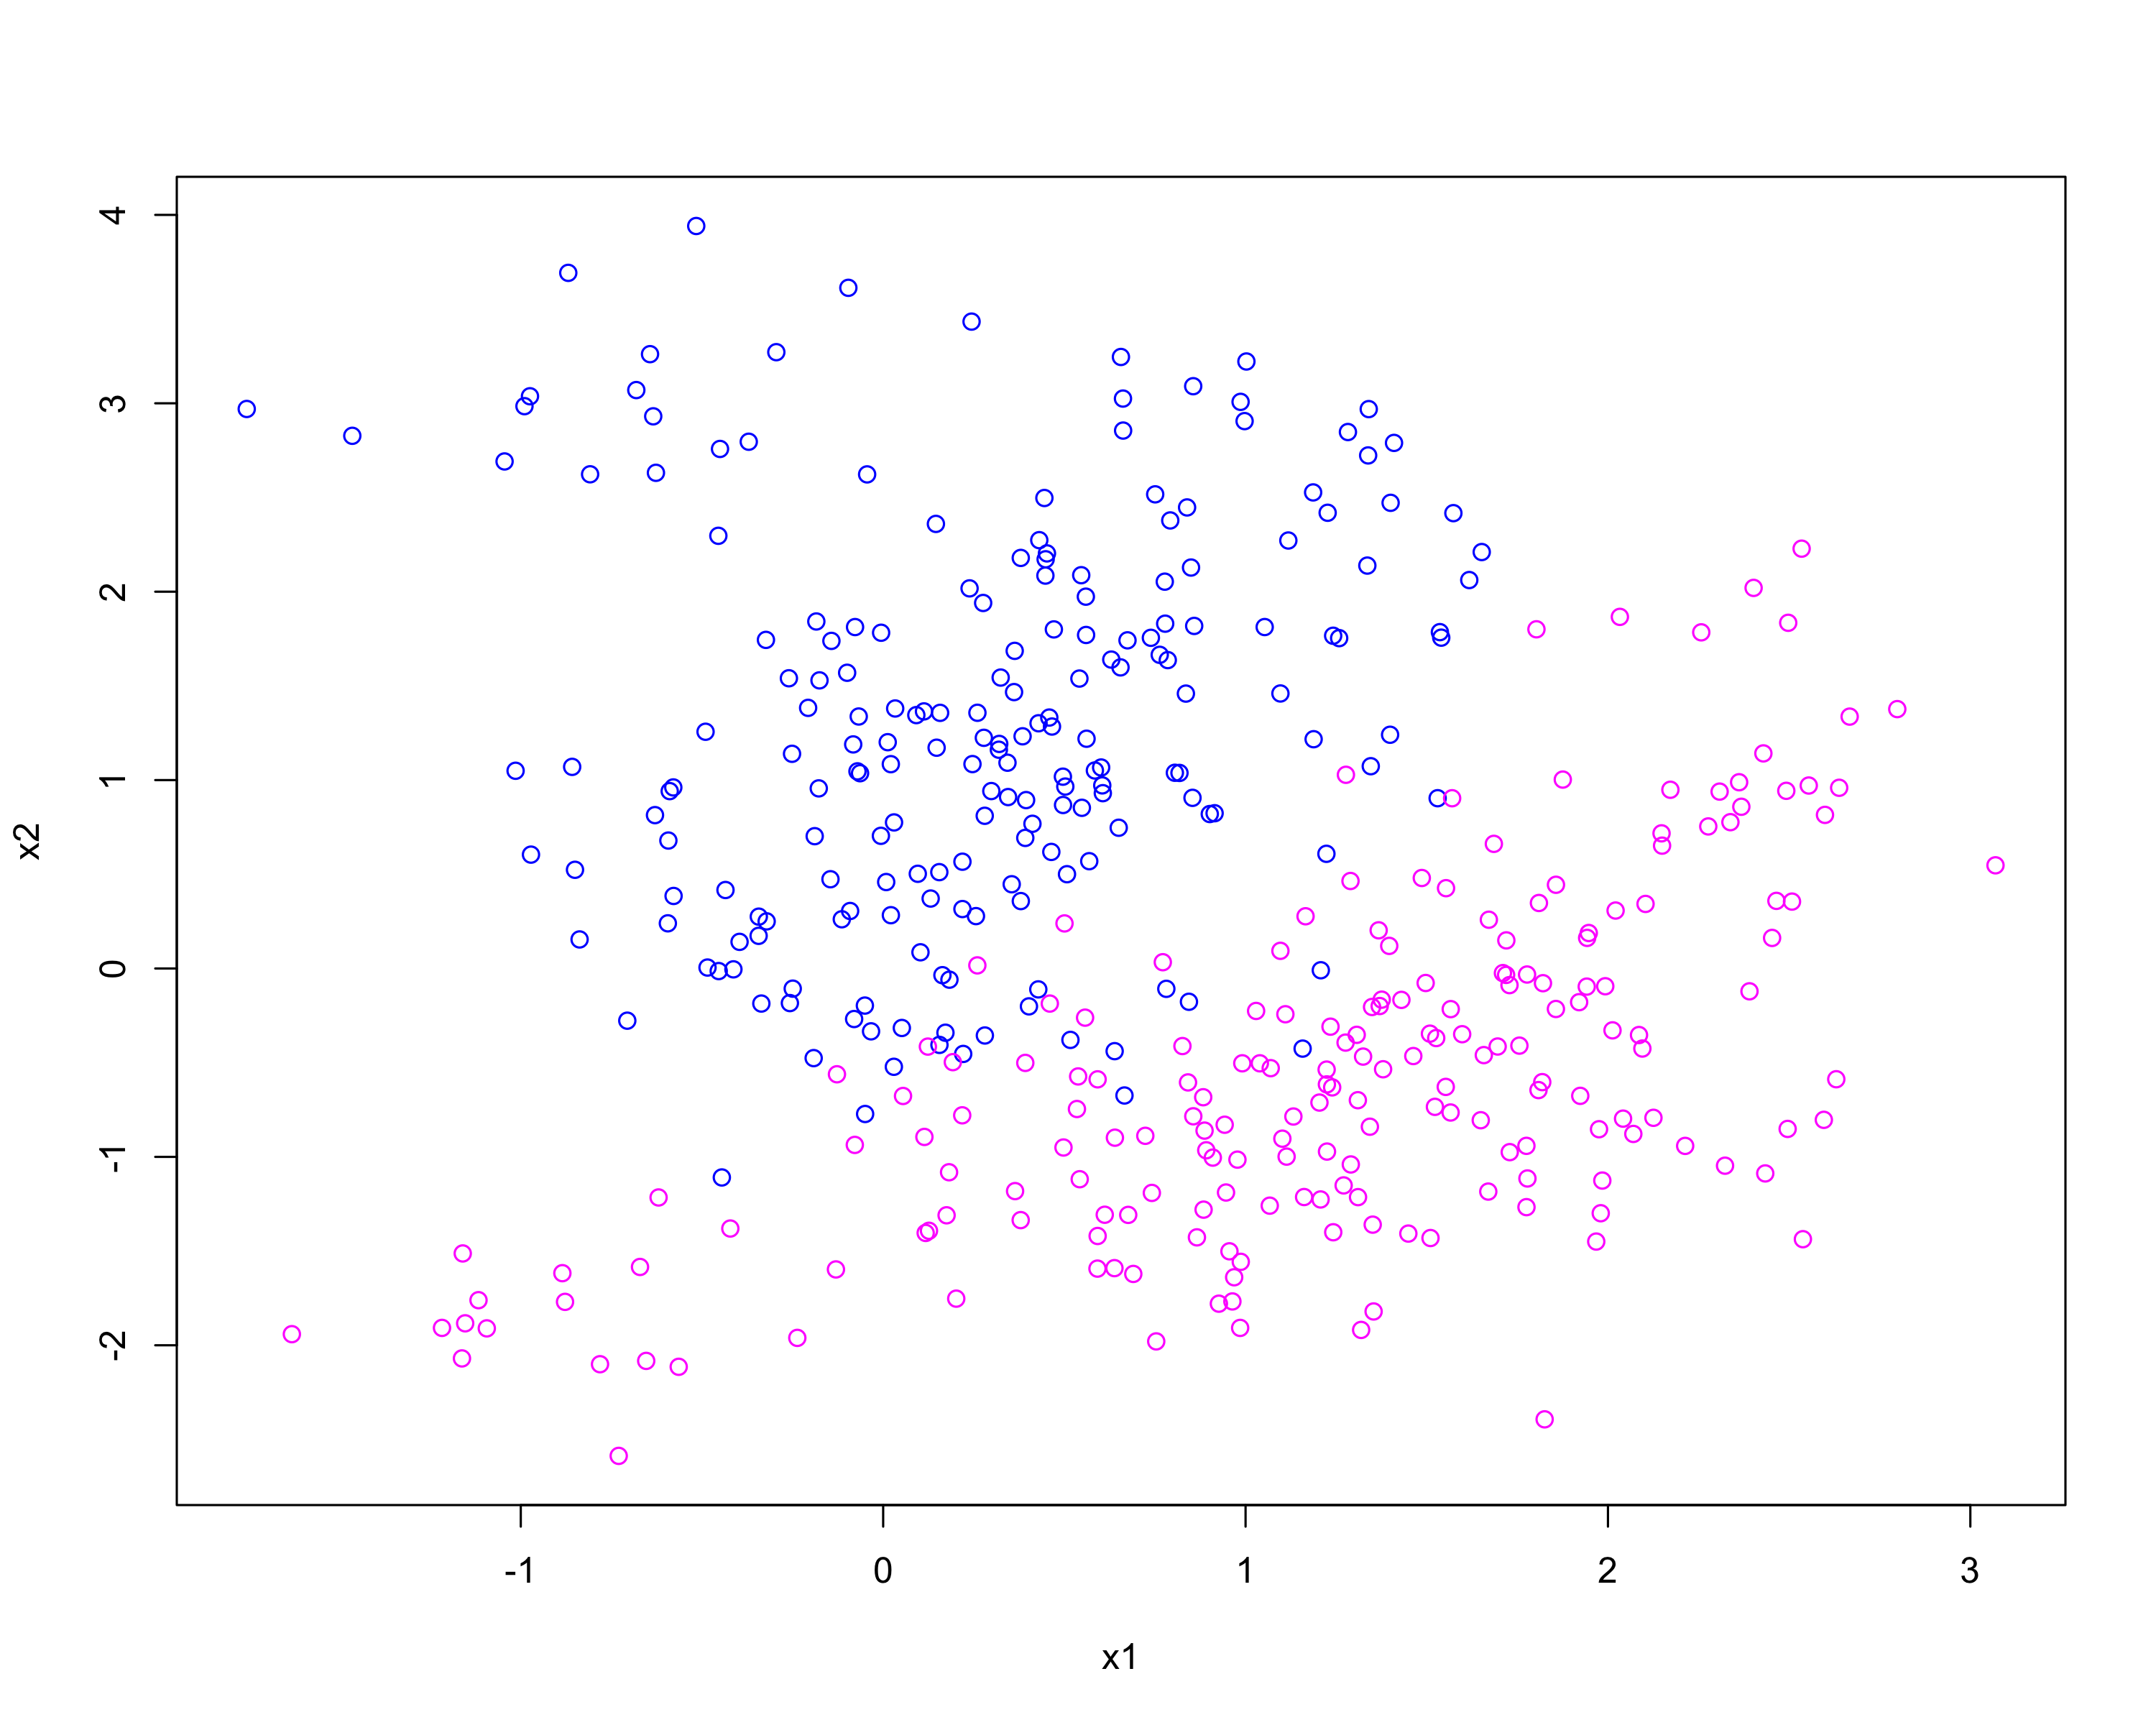

In [27]:
mask = train_data$y == -1

plot(train_data$x1[mask], train_data$x2[mask], col="blue", 
     xlim=c(min(train_data$x1),max(train_data$x1)), ylim = c(min(train_data$x2),max(train_data$x2)), 
     xlab="x1", ylab="x2")

points(train_data$x1[!mask], train_data$x2[!mask], col="magenta")

## 2. CV with tuning function

Now that we know how the mechanism works in detail, we can also just use a built in function to do this for us:

In [28]:
#install.packages("e1071") # run once

OR if you're in Anaconda, you can do in the conda environment by installing `r-e1071`.

In [29]:
library("e1071")

To use the functions here to do CV for us, we need to do some more formatting and pass vectors only instead of the nicely formatting tibble data of `train_data`.  We'll `pull` these vectors:

In [30]:
y = pull(train_data[,3]) # grab 3rd column, format into vector
x1 = pull(train_data[,1]) # pull 
x2 = pull(train_data[,2])

And bind `x1` and `x2` into a set of columns:

In [31]:
x = cbind(x1, x2)

Let's look at this data:

In [32]:
head(y)

[1] 1 1 1 1 1 1
Levels: -1 1

In [33]:
head(x)

x1,x2
1.3672969,0.20260959
-0.6539186,-2.08288915
-0.2369295,-1.96073905
2.5379501,-1.43687981
1.9925765,-0.09425896
-1.1601486,-1.51255973


We'll use the `tune.knn` function to do a CV for us, automatically:

In [34]:
knn_kfold = tune.knn(x=x, y=y, k=1:50)

In [35]:
summary(knn_kfold)


Parameter tuning of ‘knn.wrapper’:

- sampling method: 10-fold cross validation 

- best parameters:
  k
 36

- best performance: 0.0525 

- Detailed performance results:
    k  error dispersion
1   1 0.0800 0.03689324
2   2 0.0750 0.03535534
3   3 0.0700 0.03291403
4   4 0.0650 0.03162278
5   5 0.0625 0.03173239
6   6 0.0725 0.02486072
7   7 0.0575 0.02898755
8   8 0.0650 0.02934469
9   9 0.0575 0.03545341
10 10 0.0575 0.03545341
11 11 0.0550 0.03291403
12 12 0.0575 0.03545341
13 13 0.0625 0.03952847
14 14 0.0575 0.03736085
15 15 0.0575 0.04090979
16 16 0.0575 0.03343734
17 17 0.0575 0.04090979
18 18 0.0575 0.03736085
19 19 0.0550 0.03689324
20 20 0.0550 0.03689324
21 21 0.0575 0.04417453
22 22 0.0575 0.04090979
23 23 0.0550 0.03689324
24 24 0.0550 0.03689324
25 25 0.0575 0.03545341
26 26 0.0600 0.03944053
27 27 0.0575 0.03917553
28 28 0.0600 0.03944053
29 29 0.0550 0.03496029
30 30 0.0575 0.03545341
31 31 0.0575 0.03545341
32 32 0.0525 0.03622844
33 33 0.0550 0.03689324
34 34 0.0550

We can see that the above does a 10-fold CV measurement it also gives you the "best" k.  You can run this a few times to see that this "best" k changes with different random fold subsets.

We can also specify the number of folds to compare to our previous calculations like so:

In [36]:
k_folds_k = 5

knn_kfold_5 = tune.knn(x=x, y=y, k=1:50, 
                       tunecontrol=tune.control(sampling = "cross", cross=k_folds_k))

Let's grab the vector of k-folds and their associated error rate for plotting:

In [37]:
k_k5 = knn_kfold_5$performances$k
err_k5 = knn_kfold_5$performances$error

Let's plot this relationship:

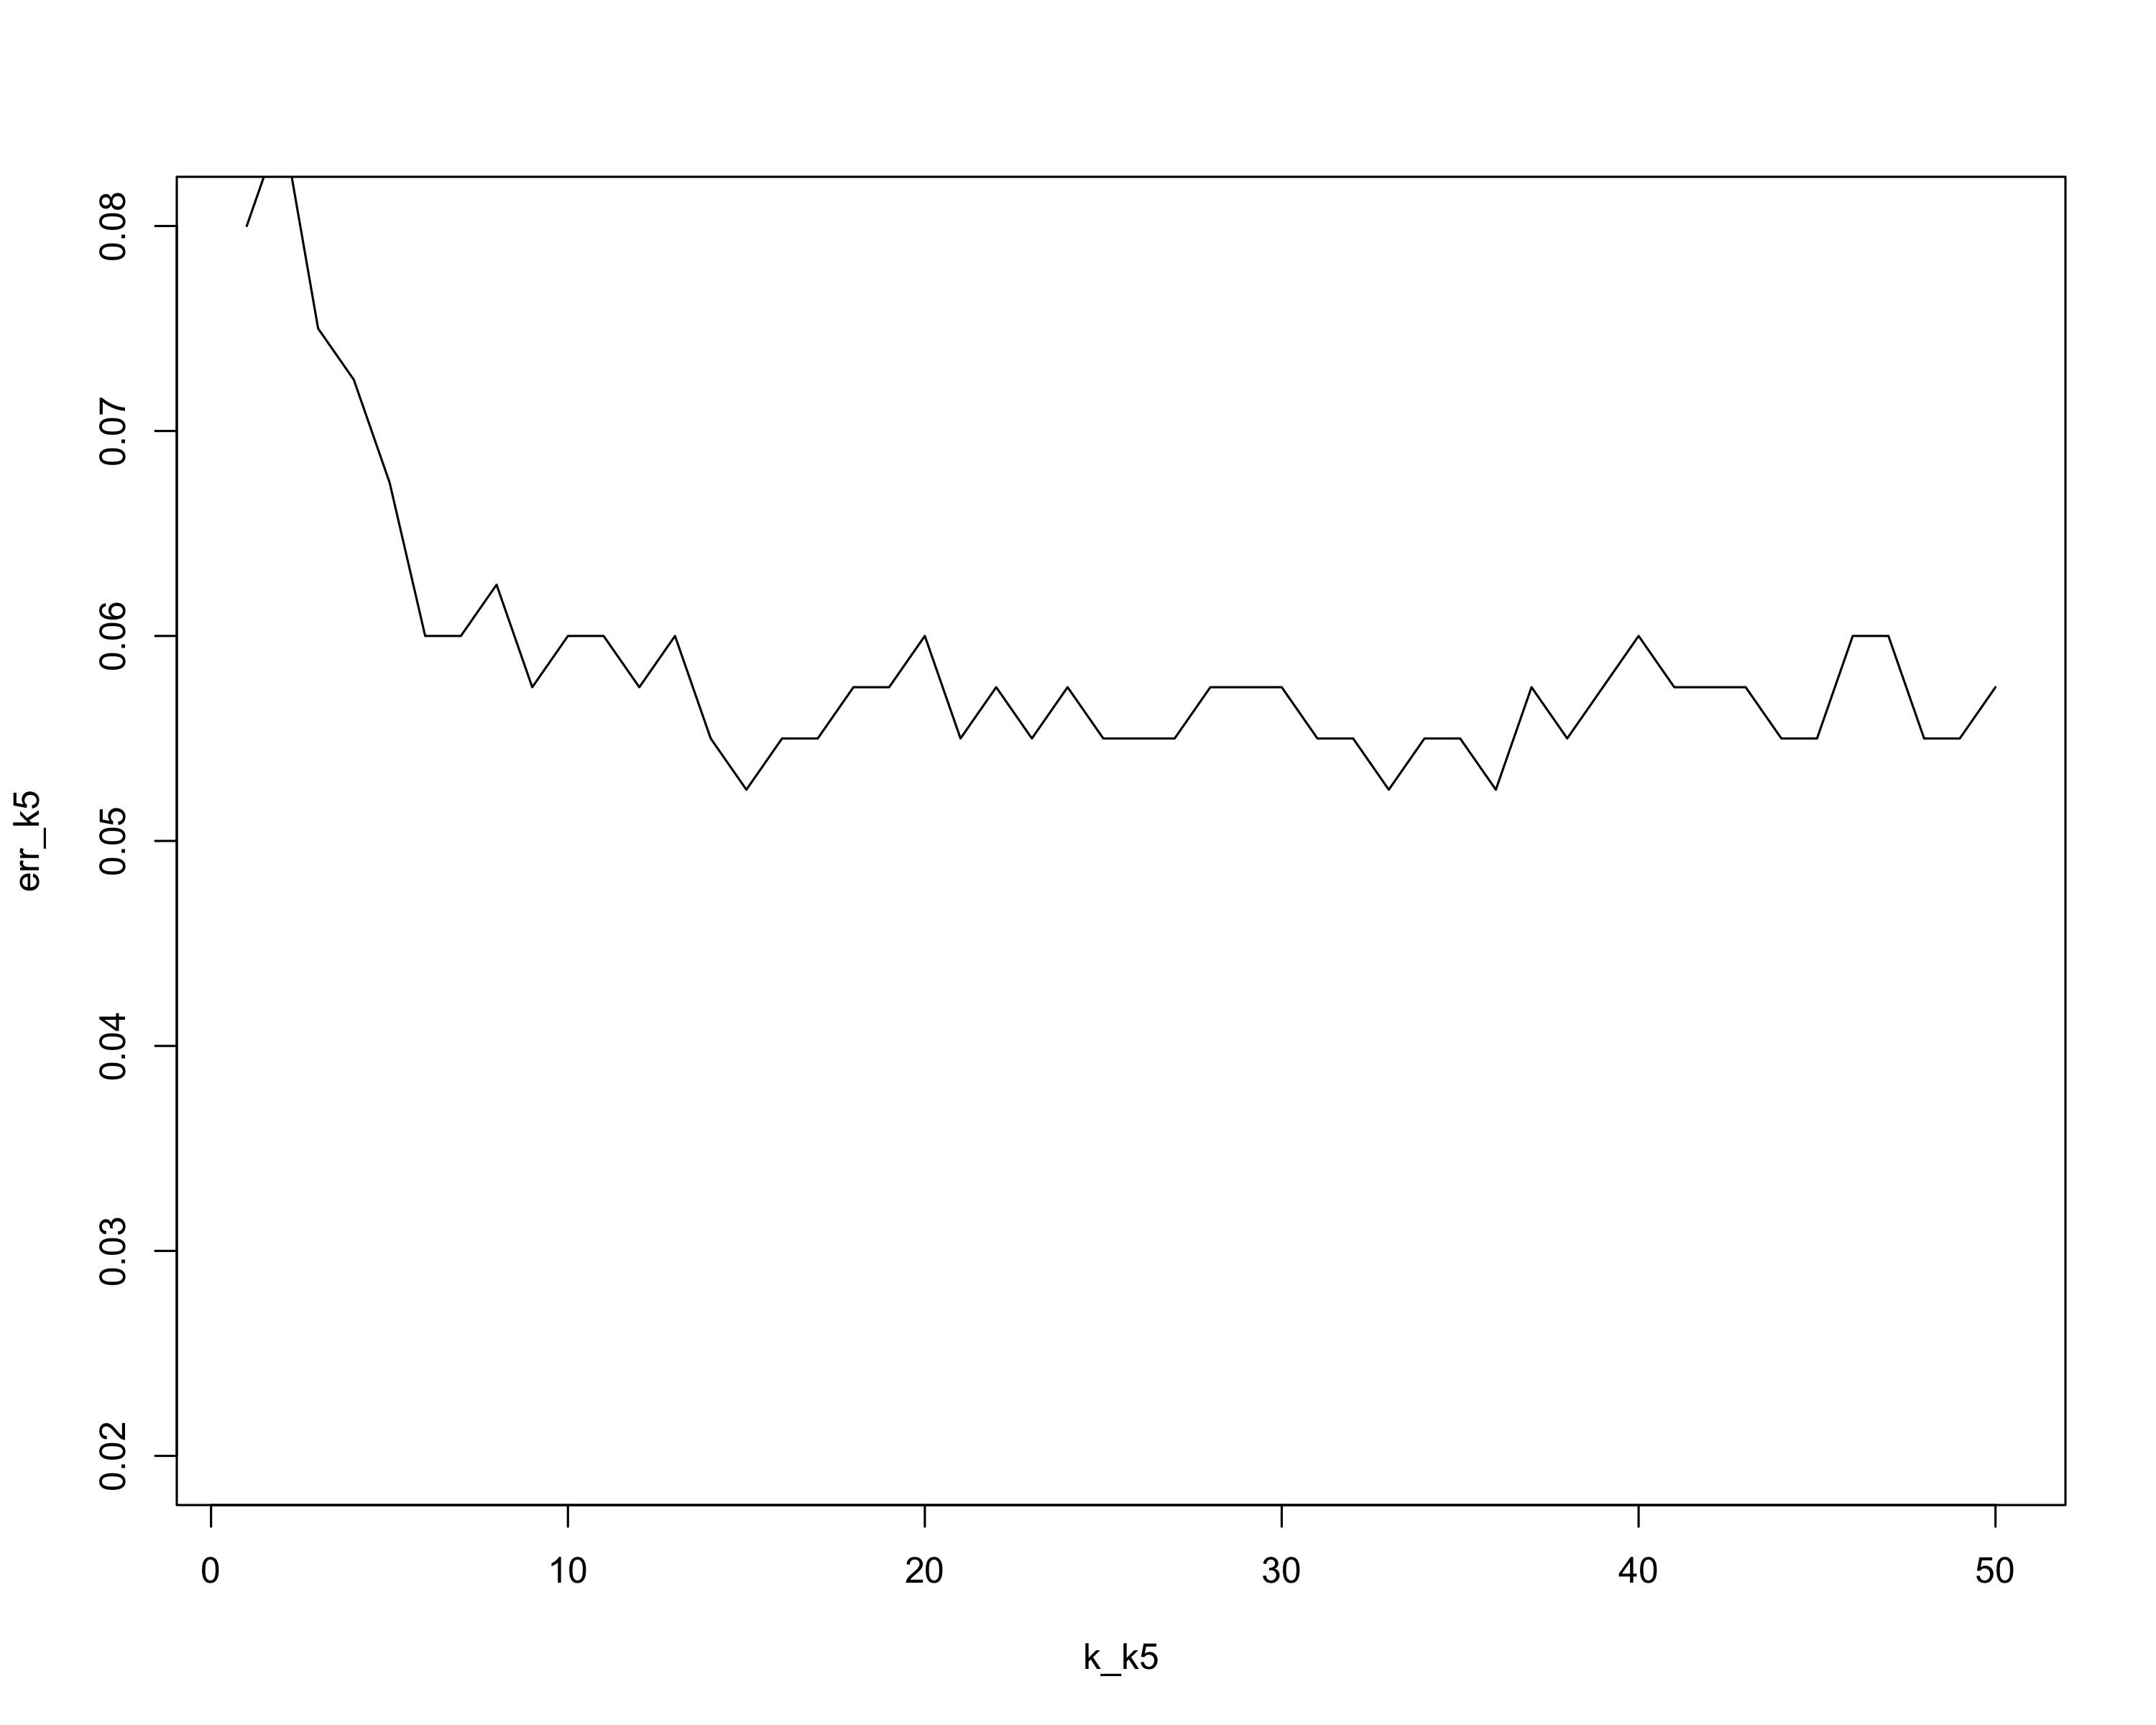

In [38]:
plot(k_k5, err_k5, col='black', type='l', ylim=c(0.02, 0.08))

Note, we can also simply do:

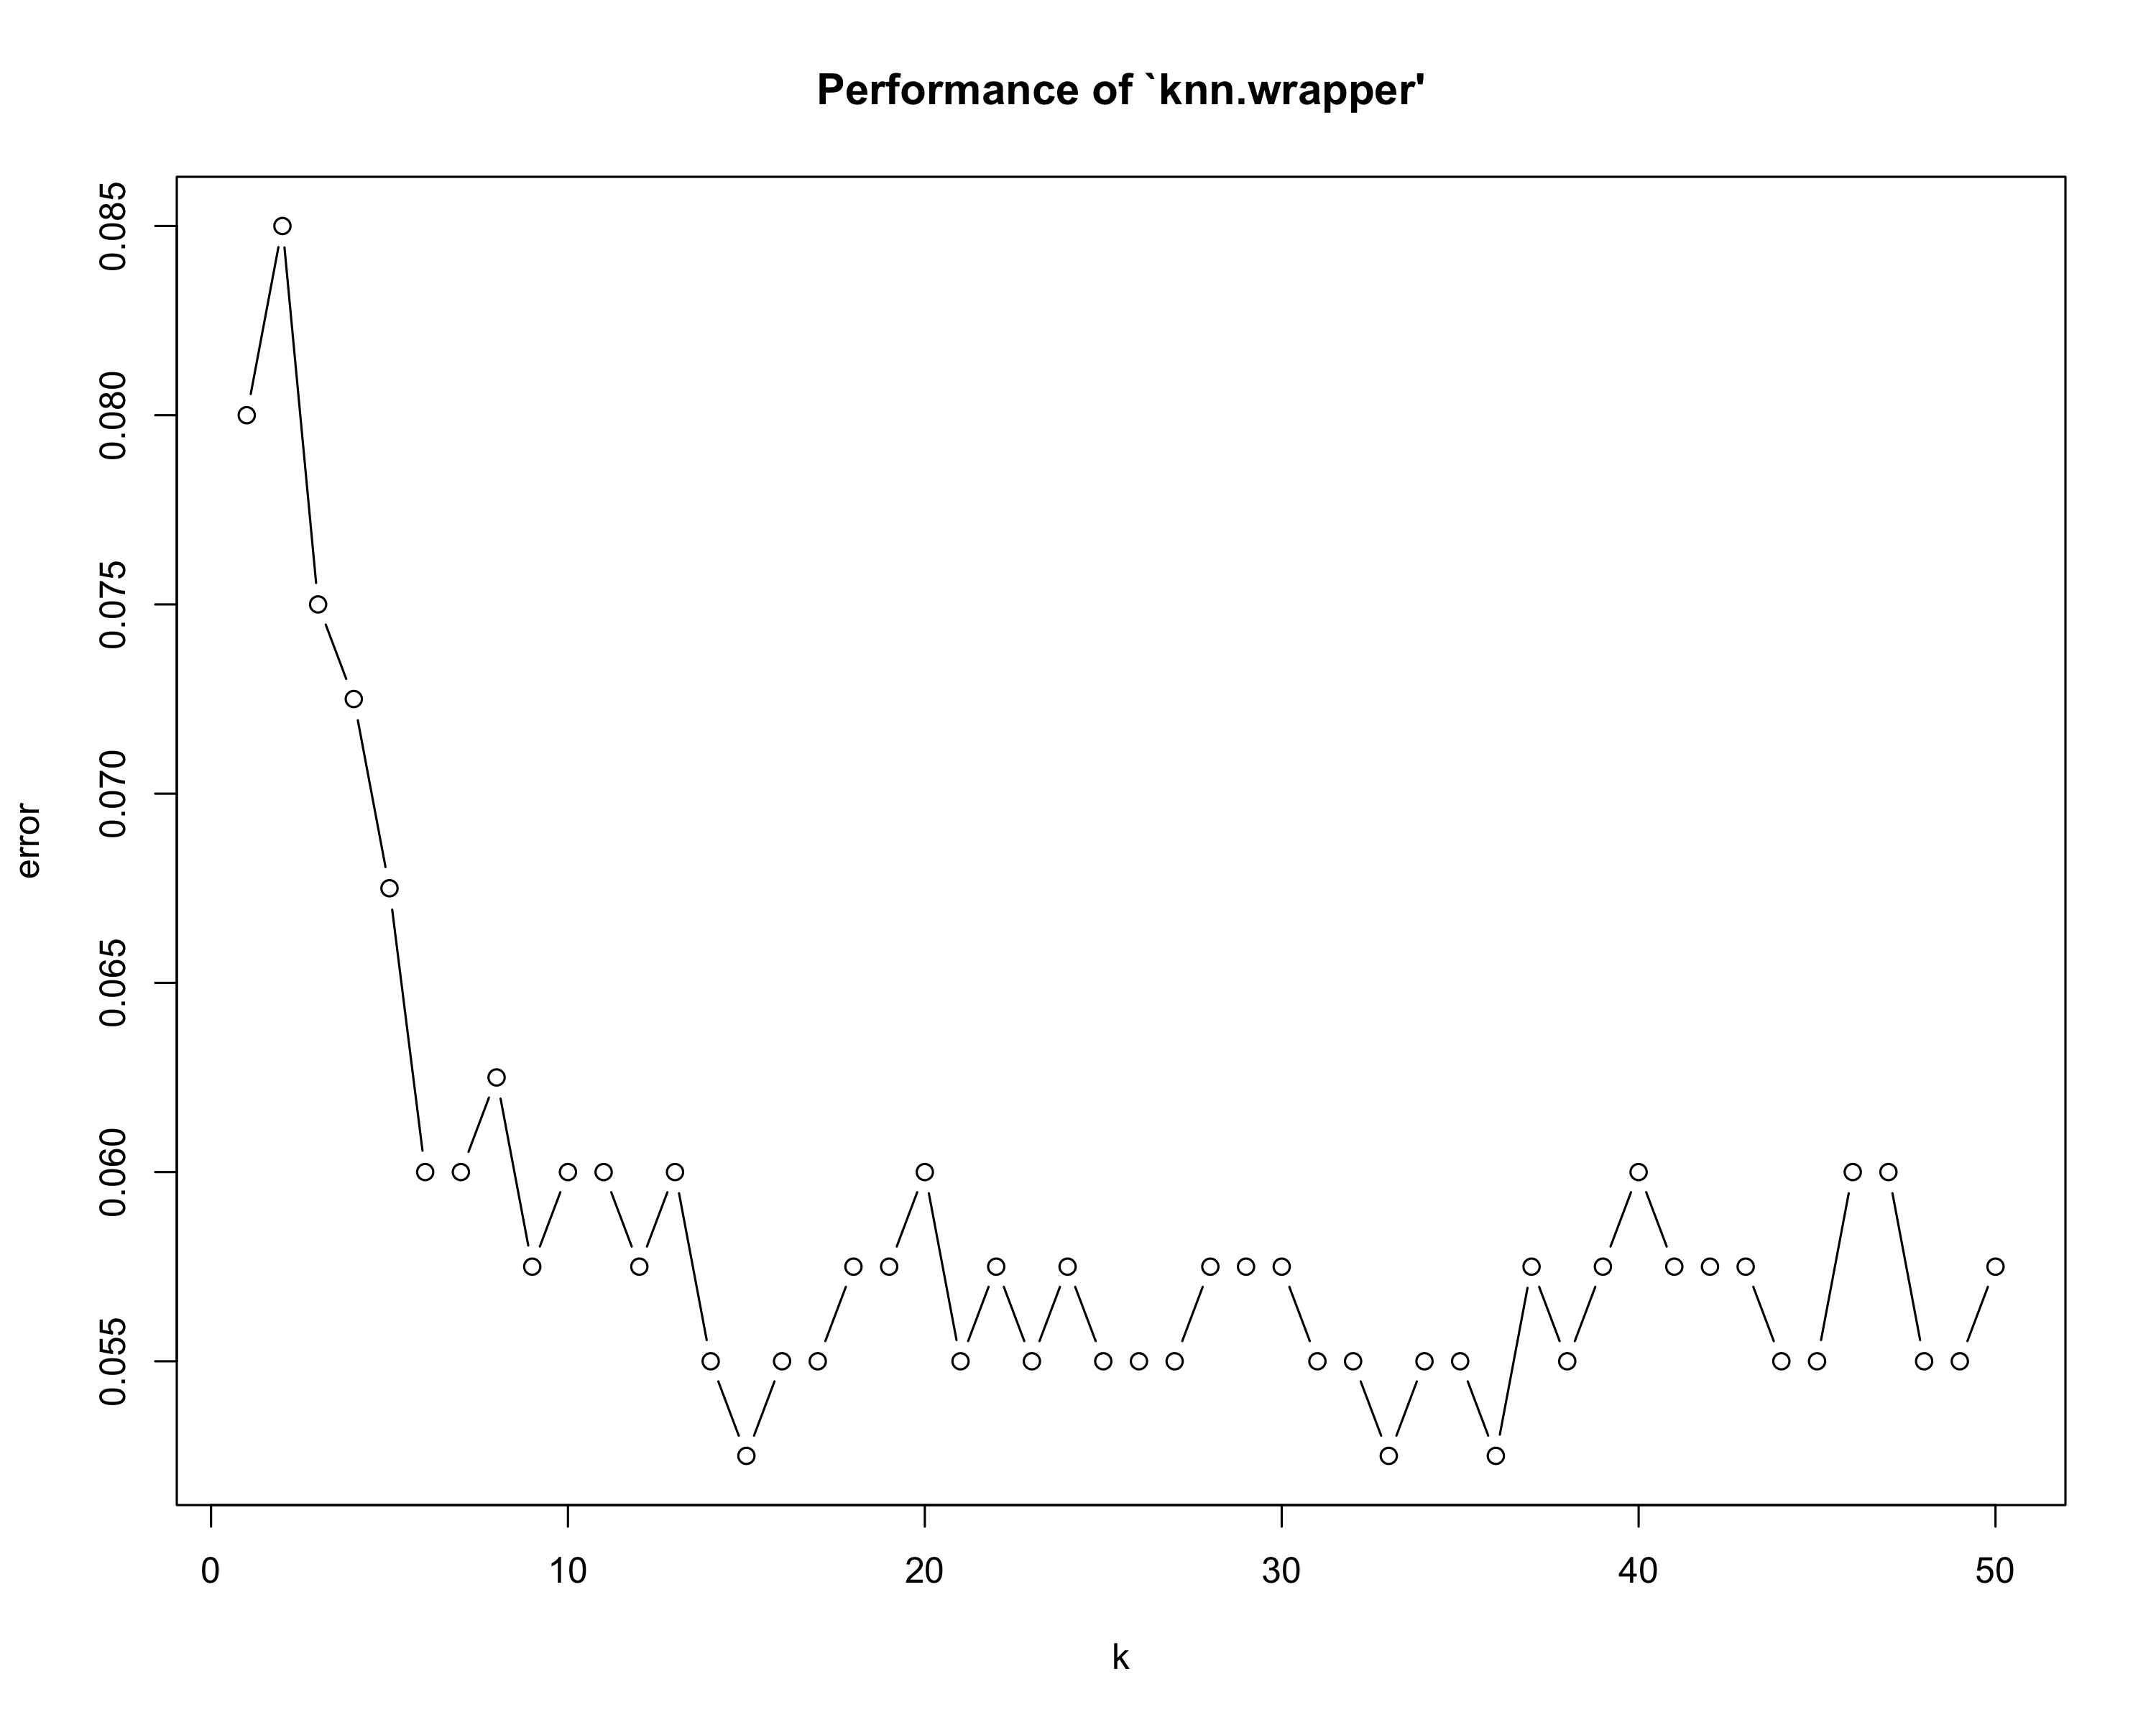

In [39]:
plot(knn_kfold_5)

## 3. TO SLIDES TO TALK ABOUT BOOTSTRAPPING

## 4. Bootstrapping with tuning function

Now, we could go through the whole example again of doing this by hand, or now that we know about the tuning function in R, let's just do that!

In [40]:
knn_boot = tune.knn(x = x, y = y, k = 1:50,tunecontrol=tune.control(sampling = "boot") )

In [41]:
summary(knn_boot)


Parameter tuning of ‘knn.wrapper’:

- sampling method: bootstrapping 

- best parameters:
  k
 20

- best performance: 0.04936251 

- Detailed performance results:
    k      error dispersion
1   1 0.07525309 0.01930988
2   2 0.08743978 0.01901516
3   3 0.07955525 0.02317791
4   4 0.07382213 0.02652953
5   5 0.06769008 0.02391212
6   6 0.06516512 0.02273401
7   7 0.06198970 0.01601668
8   8 0.05758092 0.01729230
9   9 0.05184250 0.01487537
10 10 0.05311046 0.01099315
11 11 0.05370391 0.01315751
12 12 0.05240819 0.01380777
13 13 0.05348215 0.01850171
14 14 0.05094887 0.01894213
15 15 0.05353960 0.01685512
16 16 0.05365347 0.01558978
17 17 0.05365277 0.01745179
18 18 0.05237942 0.01545936
19 19 0.05054614 0.01262689
20 20 0.04936251 0.01202430
21 21 0.05241794 0.01412912
22 22 0.05108996 0.01619539
23 23 0.05426966 0.01635256
24 24 0.05297867 0.01722762
25 25 0.05437058 0.01812865
26 26 0.05427648 0.01662599
27 27 0.05297809 0.01814905
28 28 0.05365237 0.01615503
29 29 0.05495631 0.0190

If we run this a few times we see that we get slightly different k's.

Let's compare this to our k-folds above, first by grabbing the bootstrapping k-vector and error rates...

In [42]:
k_boot = knn_boot$performances$k
err_boot = knn_boot$performances$error

...and then re-plotting and adding our bootstrapping error rate:

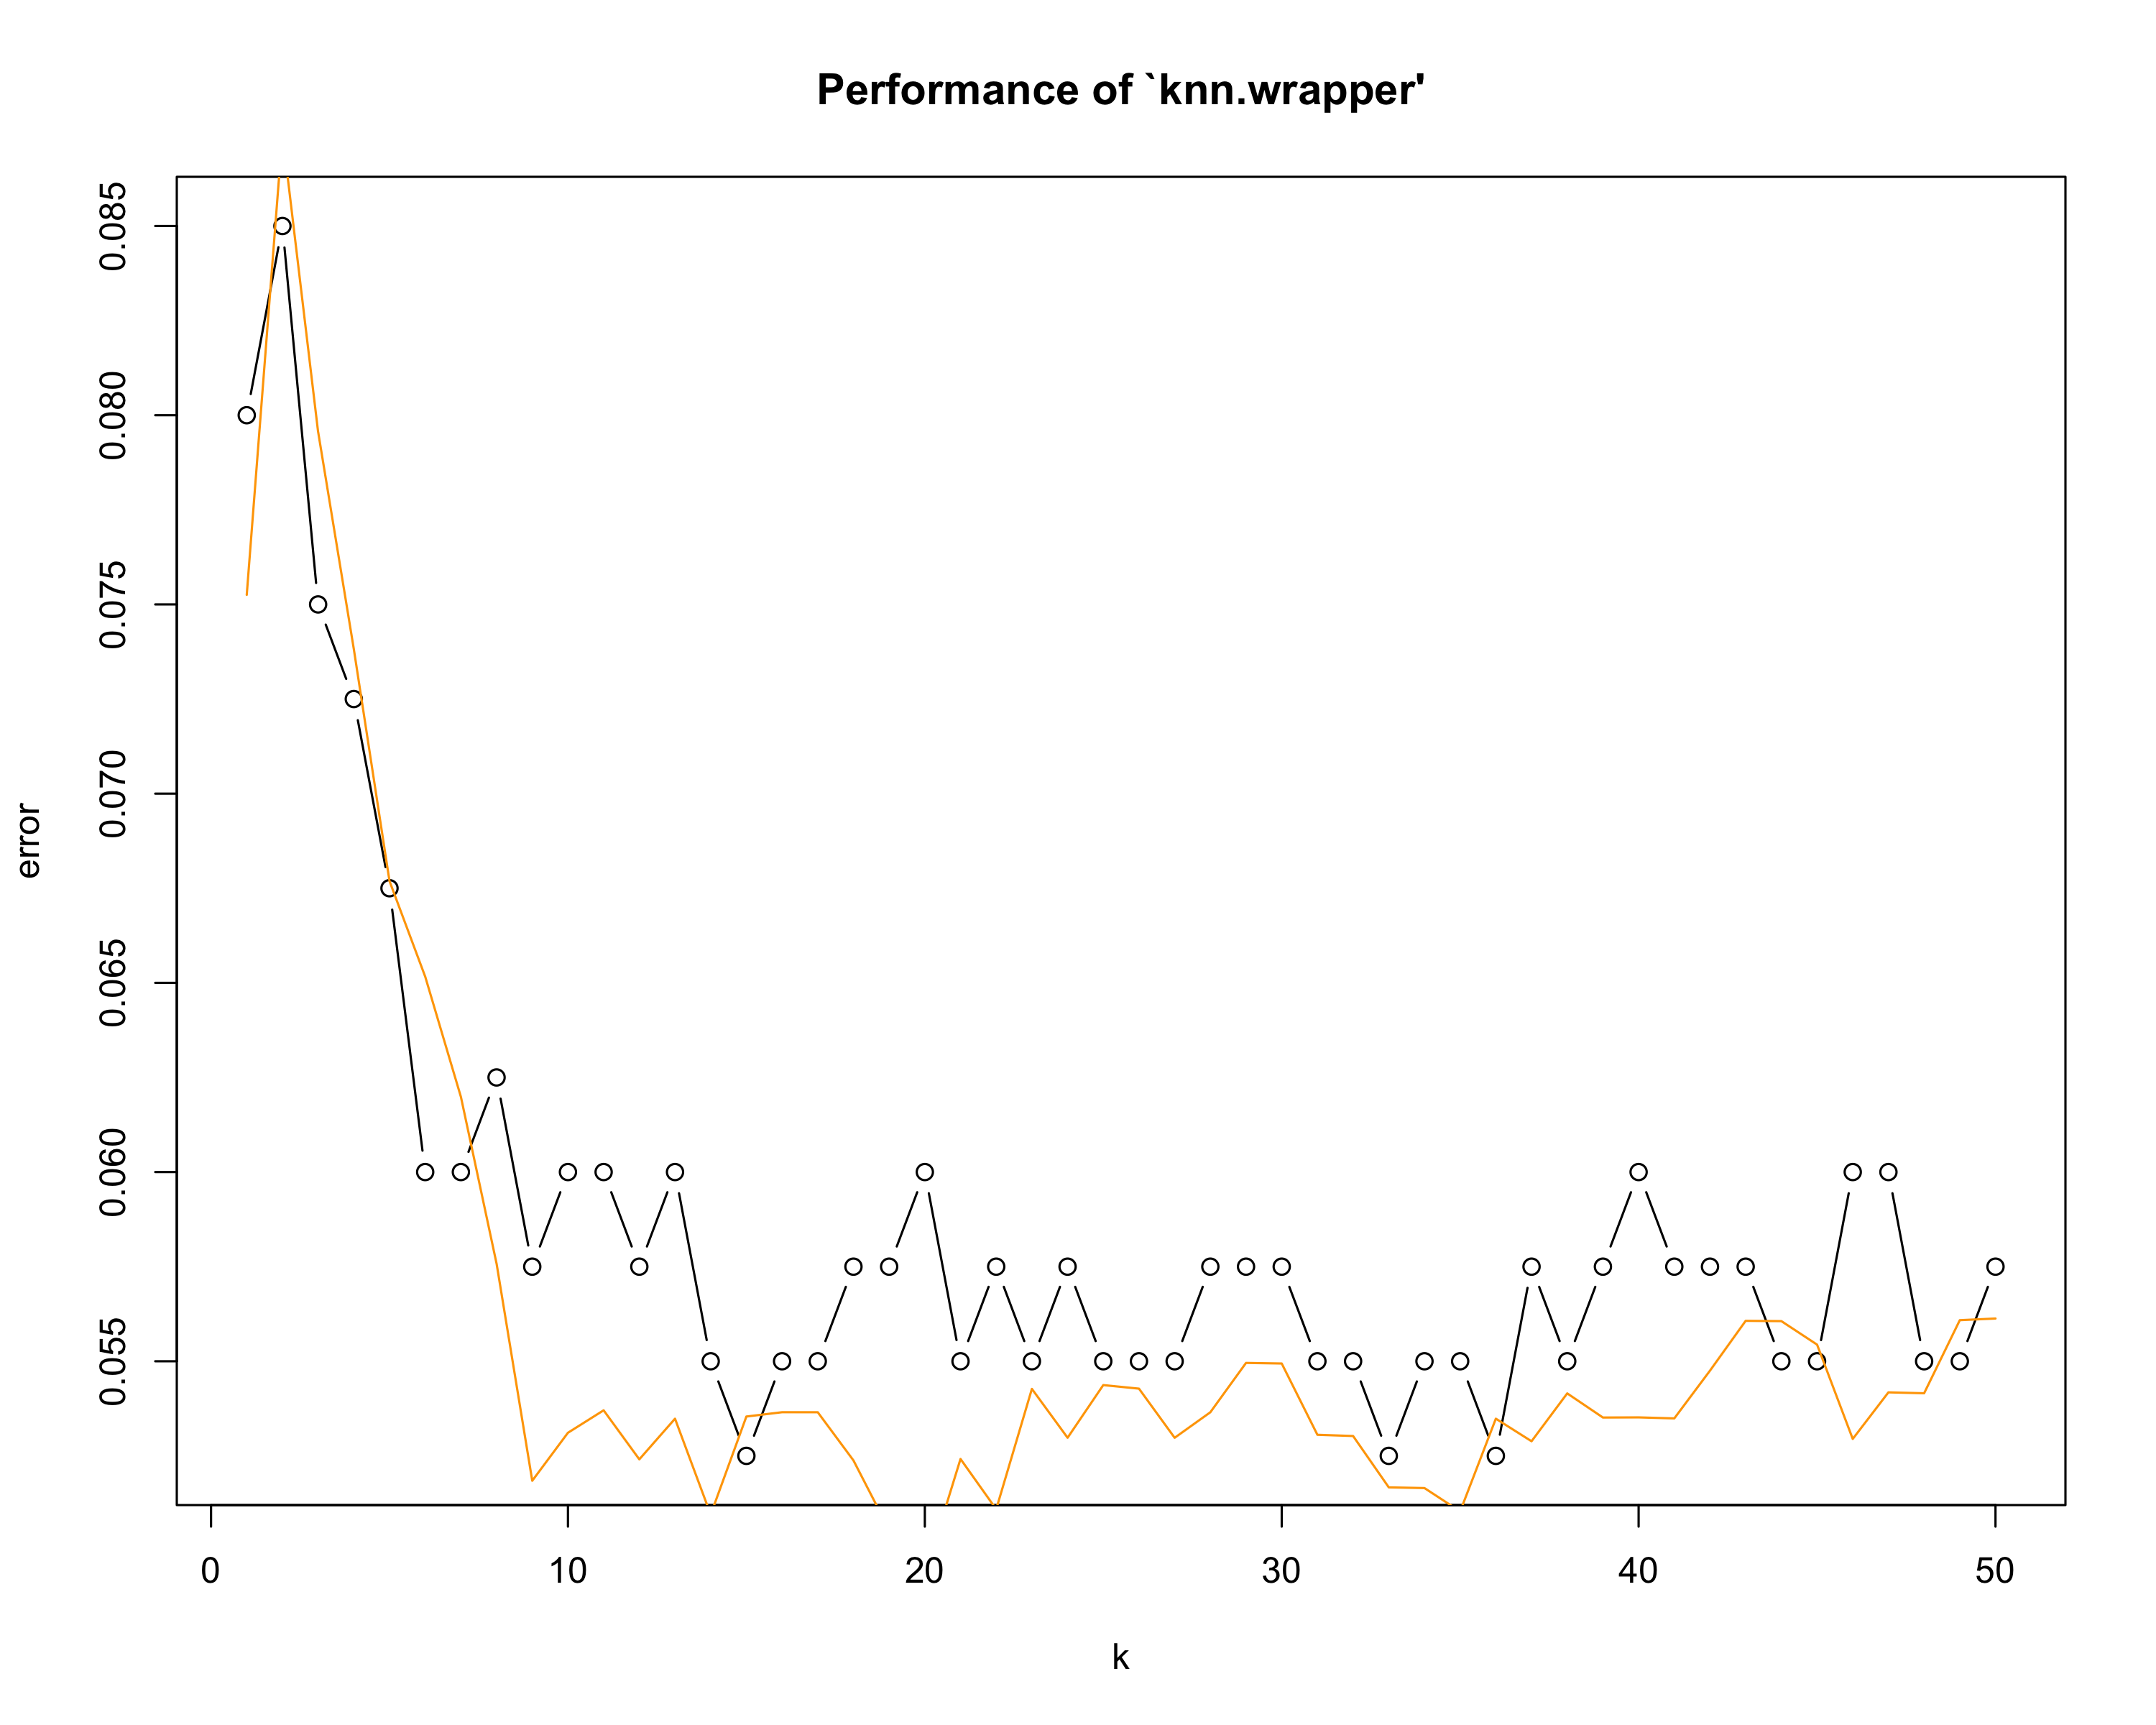

In [43]:
plot(knn_kfold_5) # knn plot

# line from bootstrapping:
lines(k_boot, err_boot, col="orange")

Again, because it is a different method, the normalization is slightly different, but overall the shape is the same.


With either method, we find k $\sim$20-30 minimizes the error.  So, let's go all the way back to plotting our KNN classification and take a look with k$\sim$20-30:

In [44]:
my_k_choice = 25

Let's use this k to make a prediction using KNN, first doing the formatting we did last week:

In [46]:
train.X = cbind(train_data$x1, train_data$x2)

# We then made a grid of new x1 & x2's
grid_size = 50 # number of new points we want to classify in x/y

# x1 & x2 ranges for fitting & plotting
x1min = -2
x1max = 4
x2min = -2
x2max = 4

x1_new = seq(x1min,x1max, length=grid_size)
x2_new = seq(x2min,x2max, length=grid_size)

new_grid.X = expand.grid(x1_new,x2_new)

prob_cut_off = 0.5

In [47]:
knn_train_prediction = knn(train.X, new_grid.X, train_data$y, k=my_k_choice, prob=T)

And grab the probability to plot with the plotting function like before:

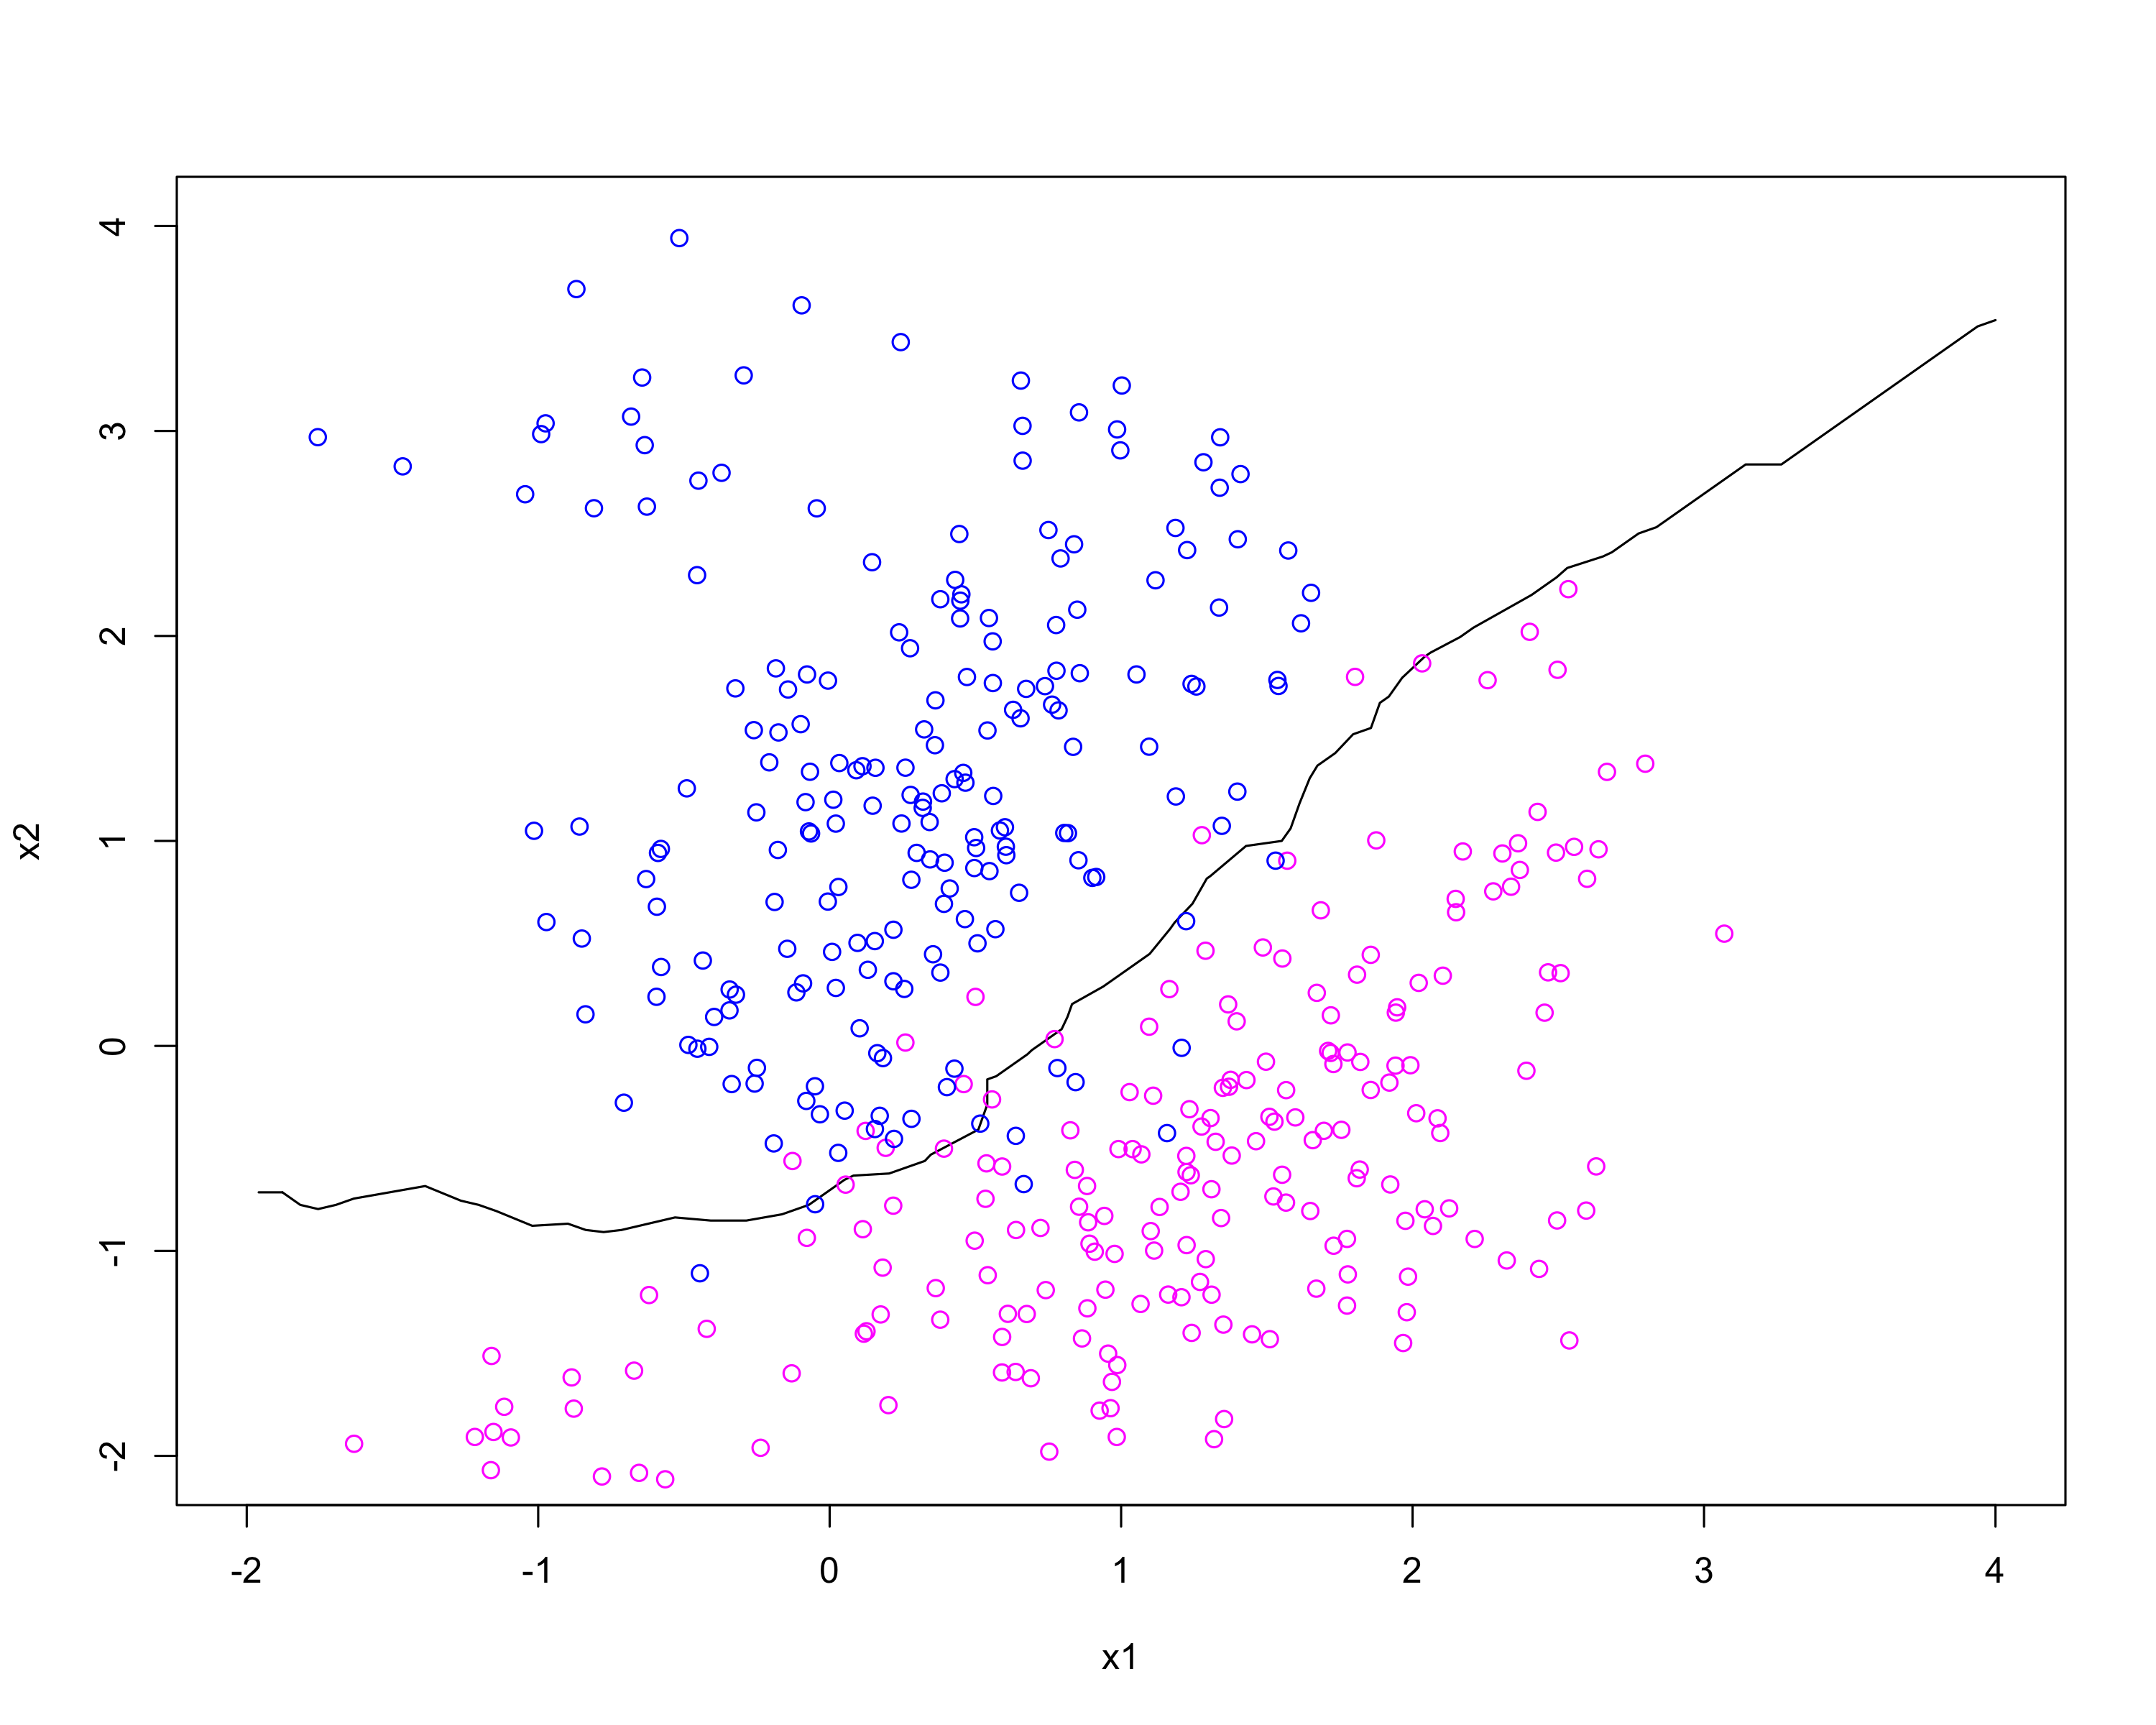

In [48]:
prob = attr(knn_train_prediction, "prob")

plot2dProbKNN(knn_train_prediction, train_data, grid_size, prob_cut_off, x1min,x1max, x2min,x2max, prob)

TADAH!!! We did it!  This is our "best" KNN model!